# Best Business Strategies for Chinook

## Introduction
In this project, we will answer to some business questions about Chinook, a fictional digital music store. The database we will be using contains information about:
* Invoice for each customer;
* Employee assigned to each customer;
* Customer;
* Playlists;
* Tracks;
* Albums;
* Music genres; 
* Media type of a track.

Using this data we will answer the following questions:
* Which is the best genre to add to the store in the USA?
* Why some employees perform better?
* Summary statistics about customers and purchases for each country.
* Do customers tend to buy whole albums or individual tracks?
* Do the protected media types influence on sales?
* Which artist is used in the most playlists?
* How many tracks have been purchased vs not purchased?
* Is the range of tracks in the store reflective of their sales popularity?

In [1]:
# Import libraries
import sqlite3
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

db = "chinook.db"

# Function to run queries
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

# Function to show all tables of database
def show_tables():
    q = '''
    SELECT 
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table", "view");
    '''
    return run_query(q)

show_tables()

name   type
0                   album  table
1                  artist  table
2                customer  table
3                employee  table
4                   genre  table
5                 invoice  table
6            invoice_line  table
7              media_type  table
8                playlist  table
9          playlist_track  table
10                  track  table
11          invoice_track   view
12  customers_per_country   view

As mentioned in the introduction we have various information about customers, employees, invoices, tracks and albums. Now that we are familiar with the database let's start answering the questions.

## What's the Best Genre to be Added in the USA?

The Chinook has signed a contract with a new label and would like to add three new artists out of four to the store on the USA market. We've been asked to analyze the existing data and decide which are the best genres to be added: Hip-Hop, Punk, Pop or Blues.

In [2]:
tracks_per_genre_usa_q = '''
WITH customer_usa_tracks AS
    (
    SELECT
        g.genre_id,
        COUNT(il.invoice_line_id) number_of_tracks,
        g.name genre_name
     FROM invoice i
    INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN genre g ON g.genre_id = t.genre_id
    WHERE billing_country = "USA"
    GROUP BY g.genre_id
    ORDER BY number_of_tracks DESC
    )
    
SELECT
    *,
    ROUND((CAST(number_of_tracks AS FLOAT) / (SELECT SUM(number_of_tracks) FROM customer_usa_tracks) * 100), 2) genre_percentage
FROM customer_usa_tracks;
'''

genre_sales_usa = run_query(tracks_per_genre_usa_q)
genre_sales_usa

genre_id  number_of_tracks          genre_name  genre_percentage
0          1               561                Rock             53.38
1          4               130  Alternative & Punk             12.37
2          3               124               Metal             11.80
3         14                53            R&B/Soul              5.04
4          6                36               Blues              3.43
5         23                35         Alternative              3.33
6          9                22                 Pop              2.09
7          7                22               Latin              2.09
8         17                20         Hip Hop/Rap              1.90
9          2                14                Jazz              1.33
10        12                13      Easy Listening              1.24
11         8                 6              Reggae              0.57
12        15                 5   Electronica/Dance              0.48
13        24                 4           Classical              0.38
14        13                 3         Heavy Metal              0.29
15        10                 2          Soundtrack              0.19
16        19                 1            TV Shows              0.10

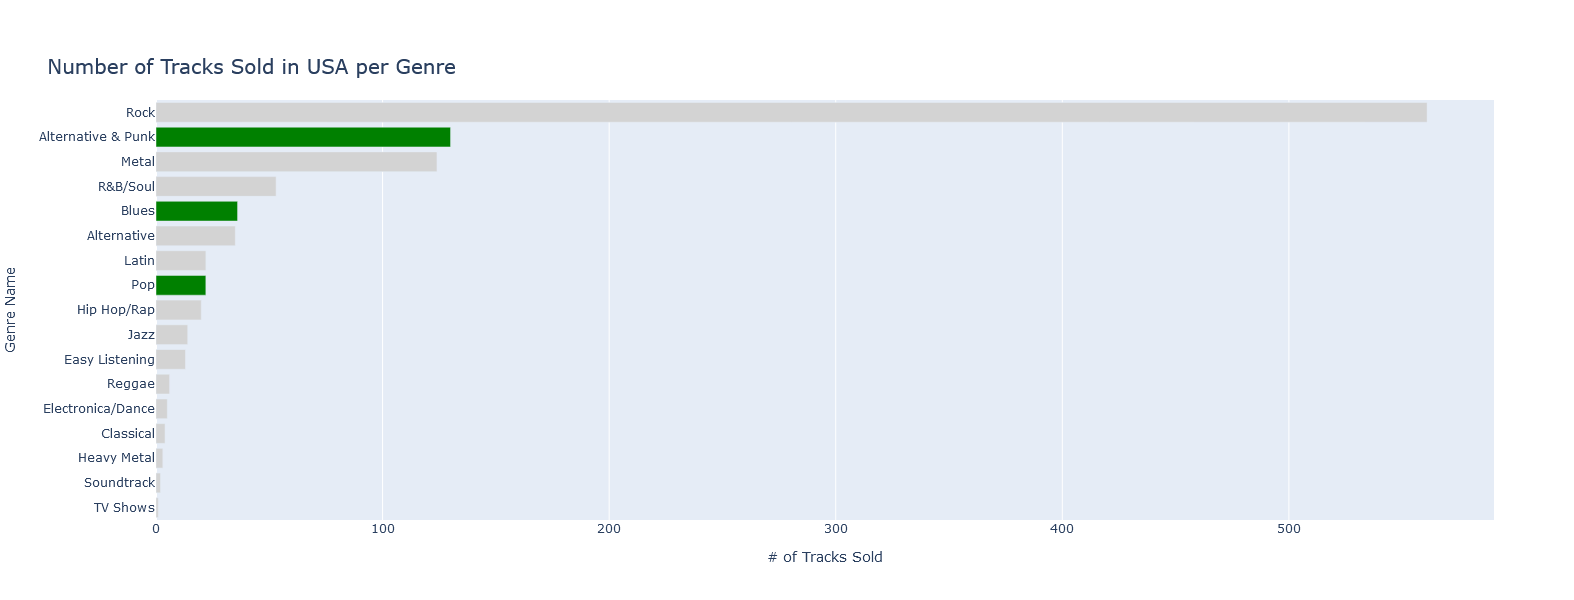

In [3]:
# Sort number of tracks in ascending order
genre_sales_usa = genre_sales_usa.sort_values(by="number_of_tracks")

# Set bar colors
colors = ["lightgray"] * 17
colors[15] = "green"
colors[12] = "green"
colors[9] = "green"
         
# Horizontal plot
fig1 = go.Figure(
        data=go.Bar(
            x=genre_sales_usa["number_of_tracks"],
            y=genre_sales_usa["genre_name"],
            orientation="h",
            marker_color=colors
    )
)

# Set axes labels and plot dimensions
fig1.update_layout(
    yaxis=dict(
        title="Genre Name",
    ),
    xaxis=dict(
        title="# of Tracks Sold",
    ),
    height=600,
    width=1000
)

# Set title position and aesthetic
fig1.update_layout(
    title={
        "text": "Number of Tracks Sold in USA per Genre",
        "x": 0.03,
        "y": 0.9,
        "font": dict(
            size=20
        )
    }
)


# Show plot
fig1.show()

We would recommend to Chinook to concentrate on: 
1. Punk;
2. Blues;
3. Pop.

It is also clear that the Rock genre dominates over the others possessing more than 50% of the USA market.

Therefore it is recommended to concentrate on these three genres but also find new labels that would provide us with some rock songs to add.

## Employees' Performance

Each customer of Chinook is assigned to a sales support agent. Some of the employees are performing better than the others so we've been asked to perform an analysis and figure out why is there this difference. We will be using the total dollar amount as the main criteria of employees' performance. We will also be using the whole invoice table, not only the USA one.

In [4]:
employee_perf_q = '''
    SELECT 
        e.employee_id, 
        e.first_name,
        e.last_name,
        e.hire_date,
        e.title,
        ROUND(SUM(i.total), 2) total
    FROM employee e
   INNER JOIN customer c ON e.employee_id = c.support_rep_id 
   LEFT JOIN invoice i ON i.customer_id = c.customer_id
   GROUP BY employee_id;
'''

run_query(employee_perf_q)

employee_id first_name last_name            hire_date                title  \
0            3       Jane   Peacock  2017-04-01 00:00:00  Sales Support Agent   
1            4   Margaret      Park  2017-05-03 00:00:00  Sales Support Agent   
2            5      Steve   Johnson  2017-10-17 00:00:00  Sales Support Agent   

     total  
0  1731.51  
1  1584.00  
2  1393.92

It's clear that longer an employee worked at the store more money they have earned during the period. Additionally, they gained more experience so probably they work better over time.

We can also calculate and average purchase value for each employee to see if the work experience influences on the ability to perform better trade operations.

In [5]:
avg_purch_empl_q = '''
    SELECT 
        e.employee_id, 
        e.first_name,
        e.last_name,
        e.title,
        e.hire_date,
        e.birthdate,
        ROUND(AVG(i.total),2 ) avg_purchase
    FROM employee e
   INNER JOIN customer c ON e.employee_id = c.support_rep_id 
    LEFT JOIN invoice i ON i.customer_id = c.customer_id
   GROUP BY employee_id;
'''

run_query(avg_purch_empl_q)

employee_id first_name last_name                title            hire_date  \
0            3       Jane   Peacock  Sales Support Agent  2017-04-01 00:00:00   
1            4   Margaret      Park  Sales Support Agent  2017-05-03 00:00:00   
2            5      Steve   Johnson  Sales Support Agent  2017-10-17 00:00:00   

             birthdate  avg_purchase  
0  1973-08-29 00:00:00          8.17  
1  1947-09-19 00:00:00          7.40  
2  1965-03-03 00:00:00          7.41

We see from the table that the average purchase value is not critically influenced by the work experience. Margaret Steve has more than five months more experience than Steve Johnson but the latter performs even slightly better. However, Jane Peacock has just one month more of work experience and she's performing better than Margaret Park. Another possible reason why Jane performs better is her younger age that might help her have a better relationship and communication with the customers. She's also probably more active in using digital stores herself (also Chinook) so she understands better her clients.

Still the available data does not give us a clear idea of what are the factors that influence the performance. It is recommended to schedule some performance reviews with each employee to understand the situation better.

## Customers' Sales Data

We've been also asked to collect some information about customers for each country. In particular, we need to calculate:

* Total number of customers.
* Total value of sales.
* Average value of sales per customer.
* Average order value.

Some countries have just one customer so we will need to merge them in the "Other" group. We will also be using the countries from the `customer` table.

First, we will calculate the total number of customers per country.

In [6]:
sales_by_country_q = '''
/* Select all customers, orders and sales for each country,
if the country has only one customer return "Other" to a new column,
and the country name otherwise */

WITH statistics_per_country AS 
    (
    SELECT
           CASE
               WHEN COUNT(DISTINCT(c.customer_id)) = 1 THEN "Other"
               ELSE c.country
            END AS country,
           COUNT(DISTINCT(c.customer_id)) num_customers,
           COUNT(DISTINCT(i.invoice_id)) num_orders,
           SUM(i.total) total_sales
    FROM customer c
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY c.country
    ),

/* Sum customers, order and sales for each country,
in this way all the Other countries will make a single group */

    sum_per_country AS
        (
         SELECT country,
                SUM(num_customers) num_customers,
                SUM(num_orders) num_orders,
                SUM(total_sales) total_sales
         FROM statistics_per_country 
         GROUP BY country
        )
    
SELECT 
    country,
    num_customers,
    ROUND(total_sales, 2) total_sales,
    ROUND(CAST(total_sales AS FLOAT) / num_customers, 2) avg_sales_per_customer,
    ROUND(CAST(total_sales AS FLOAT) / num_orders, 2) avg_order_value
 FROM
     ( 
      SELECT 
         spc.*,
         CASE
             WHEN country = "Other" THEN 1
             ELSE 0
         END AS sort
      FROM sum_per_country spc
     )
ORDER BY sort, total_sales DESC
'''

sales_by_country = run_query(sales_by_country_q)
sales_by_country

country  num_customers  total_sales  avg_sales_per_customer  \
0             USA             13      1040.49                   80.04   
1          Canada              8       535.59                   66.95   
2          Brazil              5       427.68                   85.54   
3          France              5       389.07                   77.81   
4         Germany              4       334.62                   83.66   
5  Czech Republic              2       273.24                  136.62   
6  United Kingdom              3       245.52                   81.84   
7        Portugal              2       185.13                   92.57   
8           India              2       183.15                   91.58   
9           Other             15      1094.94                   73.00   

   avg_order_value  
0             7.94  
1             7.05  
2             7.01  
3             7.78  
4             8.16  
5             9.11  
6             8.77  
7             6.38  
8             8.72  
9             7.45

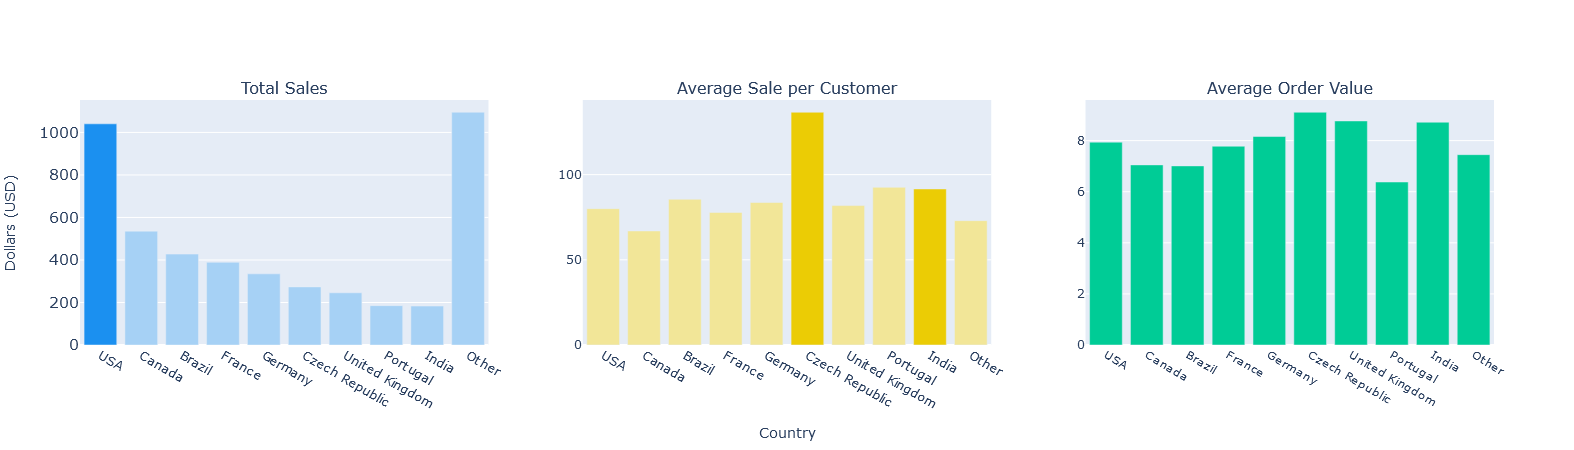

In [7]:
# Initialize 3 subplots in a row
fig2 = make_subplots(
    rows=1, cols=3,
    subplot_titles=[
        "Total Sales", 
        "Average Sale per Customer",
        "Average Order Value"
    ]
)

# Colors for the first plot
colors1 = ["#a6d1f5 "] * 10
colors1[0] = "#1b90f0"

# Colors for the second plot
colors2 = [" #f2e698"] * 10
colors2[5] = "#ebcc05"
colors2[8] = "#ebcc05"

# First plot
fig2.add_trace(
    go.Bar(
        x=sales_by_country["country"],
        y=sales_by_country["total_sales"],
        marker_color=colors1
    ),
    row=1,
    col=1
)

# Second plot
fig2.add_trace(
    go.Bar(
        x=sales_by_country["country"],
        y=sales_by_country["avg_sales_per_customer"],
        marker_color=colors2
    ),
    row=1,
    col=2,
)

# Third plot
fig2.add_trace(
    go.Bar(
        x=sales_by_country["country"],
        y=sales_by_country["avg_order_value"],
    ),
    row=1,
    col=3
)

# Remove legend
fig2.update_layout(showlegend=False)

# Axes labels
fig2.update_yaxes(title_text="Dollars (USD)", tickfont=dict(size=15), row=1, col=1)
fig2.update_xaxes(title_text="Country", row=1, col=2)
for col in range(0, 3):
    fig2.update_xaxes(row=1, col=col, tickfont=dict(size=13))

# Show plot
fig2.show()

Here what we observe:

* The maximum number of total sales is in the USA that does not surprise since it has the maximum number of customers.
* The average sales per customer in the Czech Republic is significantly higher than in other countries.
* Portugal and India follow the Czech Republic so they may be the next countries to invest to acquire new customers.
* Aside from the USA and Canada all other countries have a small number of customers so the above analysis about the Czech Republic, Portugal and India may be biased by small sample size.

The recommended country to **invest is the Czech Republic** since it has a low number of customers but a great customer's potential standing out with more than 130 euros spent on average by each customer. If the management considers some additional investments, India is good countries to invest in next since it has a high average sale per customer and a high average order value. Finally, we should not forget about the **USA since it's the biggest market** so far, and we have to support the customer's interest in our store.

## Albums or Individual Tracks

In Chinook, it is possible to buy individual tracks and whole albums. Customers cannot buy a whole album and then add individual tracks to the same purchase. Management is currently considering changing its purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album. We've been asked to calculate the percentage of purchases of individual track vs whole albums to figure out the preferences of customers.

For the analysis we have to consider the following situations:
* Some albums have only one or two tracks in them so even if a customer buys one track it's considered as a whole album.
* Some customers choose manually all tracks from an album and then add some individual track to the same purchase.

We can ignore the first case since our goal is maximizing profit. We also now from the previous analyses that the second case does not occur often. We will categorize each invoice as either an album purchase or not and calculate:
* Number of invoices.
* Percentage of the invoice for each case.

In [8]:
individual_vs_albums_q = '''
WITH invoice_first_track AS
    (
     SELECT 
         invoice_id,
         MIN(track_id) first_track_id
     FROM invoice_line
     GROUP BY 1
    )

SELECT album_purchase,
       COUNT(invoice_id) number_of_invoices,
       ROUND((CAST(COUNT(invoice_id) AS FLOAT) / (
                                           SELECT COUNT(*) 
                                           FROM invoice
                                           )) * 100, 2) "percent (%)"                              
FROM (
      SELECT 
          ift.*,
          CASE 
              WHEN
                  (
                   SELECT t.track_id
                   FROM track t
                   WHERE t.album_id = (
                                       SELECT t2.album_id
                                       FROM track t2
                                       WHERE t2.track_id = ift.first_track_id
                                       )
                                       
                    EXCEPT
                    
                    SELECT il2.track_id
                    FROM invoice_line il2
                    WHERE il2.invoice_id = ift.invoice_id  
                   ) IS NULL
                AND 
                   (
                    SELECT il2.track_id
                    FROM invoice_line il2
                    WHERE il2.invoice_id = ift.invoice_id
                    
                    EXCEPT
                    
                    SELECT t.track_id 
                    FROM track t 
                    WHERE t.album_id = (
                                        SELECT t2.album_id
                                        FROM track t2
                                        WHERE t2.track_id = ift.first_track_id
                                        ) 
                    ) IS NULL
                THEN "yes"
                ELSE "no"
            END AS "album_purchase"
            FROM invoice_first_track ift            
    )
    
GROUP by album_purchase;
'''

tracks_vs_albums = run_query(individual_vs_albums_q)
tracks_vs_albums

album_purchase  number_of_invoices  percent (%)
0             no                 500        81.43
1            yes                 114        18.57

A substantial part of customers (18%) does buy whole albums, therefore, it is not recommended to invest too much in purchasing only popular tracks for each album still it is recommended to investigate the possibility to buy some individual tracks for the albums that are usually not bought fully.

## Protected vs. Non-protected Media Types: Impact on Sales

There are two main media types: non-protected and protected. The latter was created to help publishers and content creators to protect their works from being copied (usually illegally). To this objection, there were created some tools like [DRM](https://en.wikipedia.org/wiki/Digital_rights_management). However, [it was argued](www.cbc.ca/news/technology/story/2009/08/06/tech-digital-locks-drm-tpm-rights-management-protection-measures-copyright-copy-protection.html) that this protection creates more problems than benefits like restricting users from lending the work, creating backups and even blocking them from using the content if the service is discontinued. Some of these drawbacks may have a strong impact on sales: people would prefer not to risk their money buying a protected song.

Therefore, we will investigate if the non-protected media has any benefit to the protected media. We will count the number of tracks sold per each media type to figure out customers' preferences.

In [9]:
protected_vs_non_protected_q = '''
    WITH protected_type AS 
        (
         SELECT 
               *,
               CASE 
                  WHEN name LIKE "Protected%" THEN "Protected" 
                  ELSE "Not Protected"
               END AS "protected"
         FROM media_type mt
        ),
        
        il_total_quantity AS 
        (
         SELECT SUM(quantity) total_quantity
         FROM invoice_line
        )
        
    SELECT protected,
           SUM(il.quantity) tracks_sold,
           ROUND(CAST(SUM(il.quantity) AS FLOAT) / (SELECT total_quantity FROM il_total_quantity), 3) * 100 percentage
    FROM protected_type pt
    INNER JOIN track t ON t.media_type_id = pt.media_type_id
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    GROUP BY protected
'''
protected_vs_non_protected = run_query(protected_vs_non_protected_q)
protected_vs_non_protected

protected  tracks_sold  percentage
0  Not Protected         4315        90.7
1      Protected          442         9.3

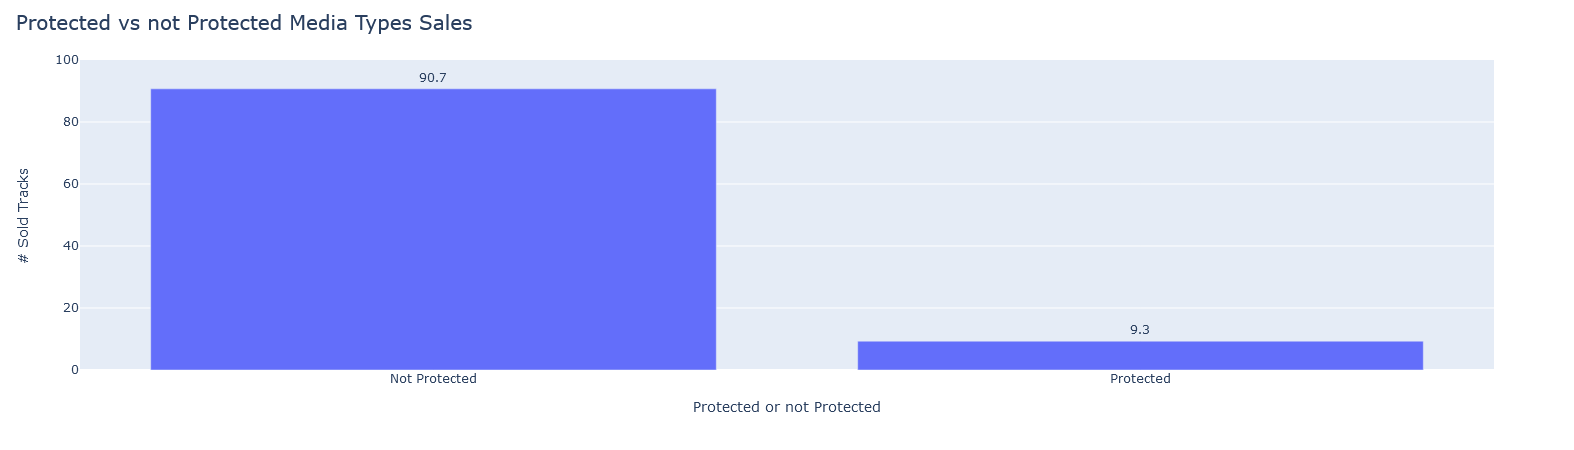

In [10]:
# Plot: tracks sold by genre
fig3 = px.bar(protected_vs_non_protected, x="protected", y="percentage", text="percentage")

# Data labels
fig3.update_traces(texttemplate="%{text}", textposition="outside")

# Title
fig3.update_layout(
    title={
        "text":"Protected vs not Protected Media Types Sales",
        "x": 0.01,
        "font": dict(
            size=20
        )
    }
)

# Axes' labels and range
fig3.update_xaxes(title="Protected or not Protected")
fig3.update_yaxes(title="# Sold Tracks", range=[0, 100])

More than 90% of all sold tracks are of not protected media types, therefore it is recommended to **prefer non-protected audio files over the protected ones**.

## The Most Popular Artists in Playlists

The management has decided to buy more tracks by the most popular artists, it is also useful to prioritize the artists which tracks should be bought first. We've been asked by Chinook to find out the most popular artists in playlists created by users. 

In [11]:
popular_artists_q = '''
    SELECT 
        ar.name,
        SUM(DISTINCT(pt.playlist_id)) no_playlists
    FROM artist ar
    INNER JOIN album al ON ar.artist_id = al.artist_id
    INNER JOIN track t ON t.album_id = al.album_id
    INNER JOIN playlist_track pt ON pt.track_id = t.track_id
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 5;
'''

popular_artists = run_query(popular_artists_q)
popular_artists

name  no_playlists
0                                     Eugene Ormandy            68
1                   English Concert & Trevor Pinnock            55
2  Academy of St. Martin in the Fields & Sir Nevi...            55
3                                 The King's Singers            53
4      Berliner Philharmoniker & Herbert Von Karajan            53

The artists that are used in most playlists are:
* Eugene Ormandy.
* English Concert & Trevor Pinnock.
* Academy of St. Martin in the Fields.
* The King's Singers.
* Berliner Philharmoniker & Herbert Von Karajan.

Most of them are known for their contribution in orchestras. Considering the fact that most of the tracks sold in the USA (the biggest market) are rock/punk/metal compositions **it is not recommended to prioritize the orchestras'**.

## Tracks: Purchased vs. Not Purchased

It is very important to understand if people tend to buy the whole range of track available in the store. We've been asked to figure out the percentage of the tracks sold out of the total available tracks.

In [12]:
purchased_vs_not_purchased_tracks_q = '''
    WITH purchased_tracks AS 
        (
         SELECT il.track_id
         FROM invoice_line il
         GROUP BY il.track_id
        )
        
    SELECT 
        COUNT(*) purchased_tracks,
        (SELECT COUNT(*) FROM track) - COUNT(*) not_purchased_tracks,
        ROUND(CAST(COUNT(*) AS FLOAT) / (SELECT COUNT(*) FROM track), 3) * 100 percentage_purchased,
        (SELECT COUNT(*) FROM track) total_tracks
        FROM purchased_tracks
    '''

purchased_vs_not_purchased_tracks = run_query(purchased_vs_not_purchased_tracks_q)
purchased_vs_not_purchased_tracks

purchased_tracks  not_purchased_tracks  percentage_purchased  total_tracks
0              1806                  1697                  51.6          3503

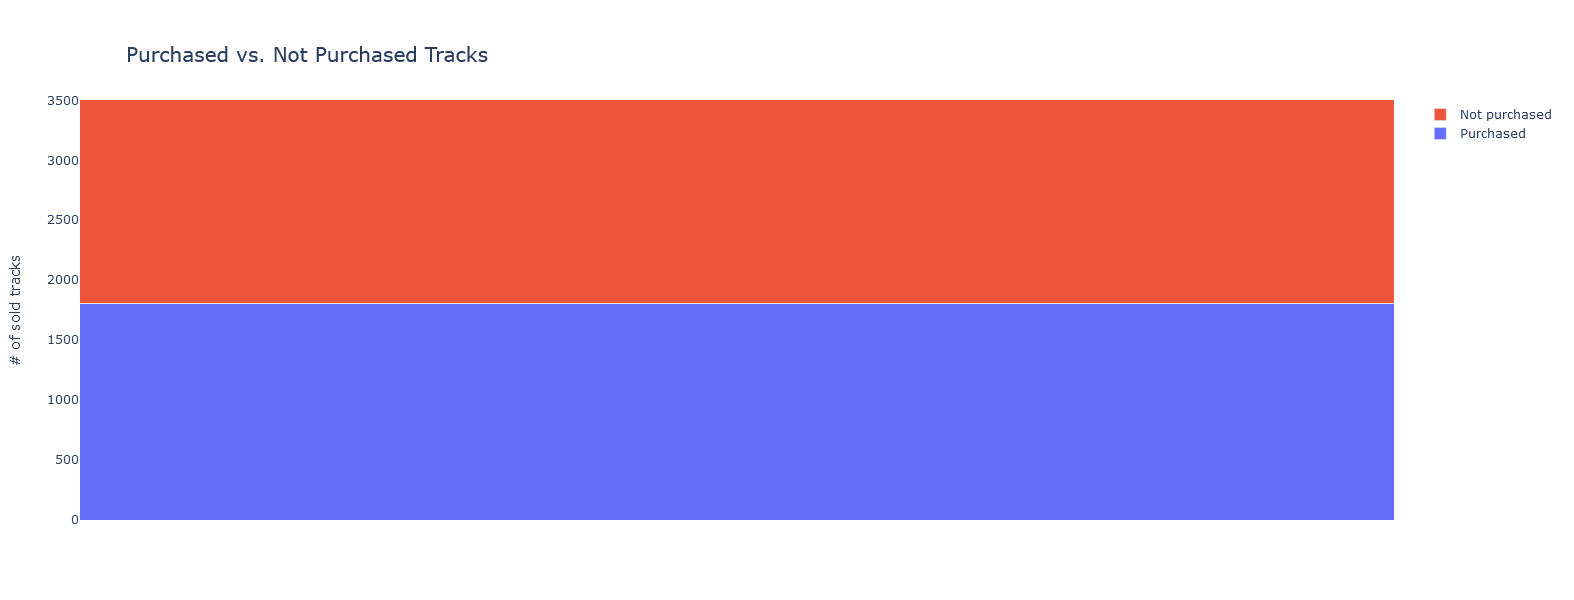

In [13]:
# Stacked bar chart: purchased vs. not purchased
fig4 = go.Figure(data=[
    go.Bar(name='Purchased', y=[1806], width=1, text="purchased_tracks"),
    go.Bar(name='Not purchased', y=[1697], width=1, text="not_purchased_tracks")
])

fig4.update_layout(
    height=600,
    width=500,
    barmode='stack'
)

# Title
fig4.update_layout(
    title={
        "text": "Purchased vs. Not Purchased Tracks",
        "x": 0.08,
        "y": 0.92,
        "font": dict(
            size=20
        )
    }
)

# y axis label and remove x tick labels
fig4.update_yaxes(title="# of sold tracks", range=[0, 3503])
fig4.update_xaxes(showticklabels=False)

**Almost half of the available tracks in Chinook is not purchased**, therefore it is recommended to reconsider the sales policy. We will investigate this issue further and find out which genres have from this problem.

We will further investigate the sales popularity  in the next section.

## Range of Tracks and Sales Popularity

The management of Chinook wants to reduce losses from buying the tracks that are not very popular among customers. We will group tracks by genre and count:

* Number of available tracks.
* Number of sold tracks.
* Percentage of sold tracks.

In [14]:
sales_popularity_q = '''
    WITH available_tracks AS 
        (
         SELECT
             g.genre_id,
             g.name,
             COUNT(*) no_tracks
         FROM track t
         INNER JOIN genre g ON g.genre_id = t.genre_id 
         GROUP BY 1
        ),

         purchased_tracks AS 
            (
             SELECT
                 g.genre_id,
                 g.name genre_name,
                 COUNT(DISTINCT(il.track_id)) unique_tracks_sold           
             FROM invoice_line il
             INNER JOIN track t ON t.track_id = il.track_id
             INNER JOIN genre g ON g.genre_id = t.genre_id
             GROUP BY g.name
            )

    SELECT
        at.name,
        at.no_tracks,
        pt.unique_tracks_sold,
        ROUND(CAST(pt.unique_tracks_sold AS FLOAT) / at.no_tracks, 3) * 100 percentage_sold
    FROM available_tracks at 
    INNER JOIN purchased_tracks pt ON pt.genre_id = at.genre_id
    ORDER BY percentage_sold;
'''

sales_popularity = run_query(sales_popularity_q)
sales_popularity.sort_values(by="percentage_sold")

name  no_tracks  unique_tracks_sold  percentage_sold
0                Drama         64                   1              1.6
1             TV Shows         93                   2              2.2
2           Soundtrack         43                   5             11.6
3                Latin        579                 119             20.6
4            Classical         74                  16             21.6
5          Heavy Metal         28                   7             25.0
6               Reggae         58                  22             37.9
7                 Jazz        130                  61             46.9
8                  Pop         48                  25             52.1
9   Alternative & Punk        332                 176             53.0
10         Hip Hop/Rap         35                  21             60.0
11               Metal        374                 238             63.6
12               Blues         81                  56             69.1
13                Rock       1297                 915             70.5
14         Alternative         40                  34             85.0
15            R&B/Soul         61                  55             90.2
16   Electronica/Dance         30                  29             96.7
17      Easy Listening         24                  24            100.0

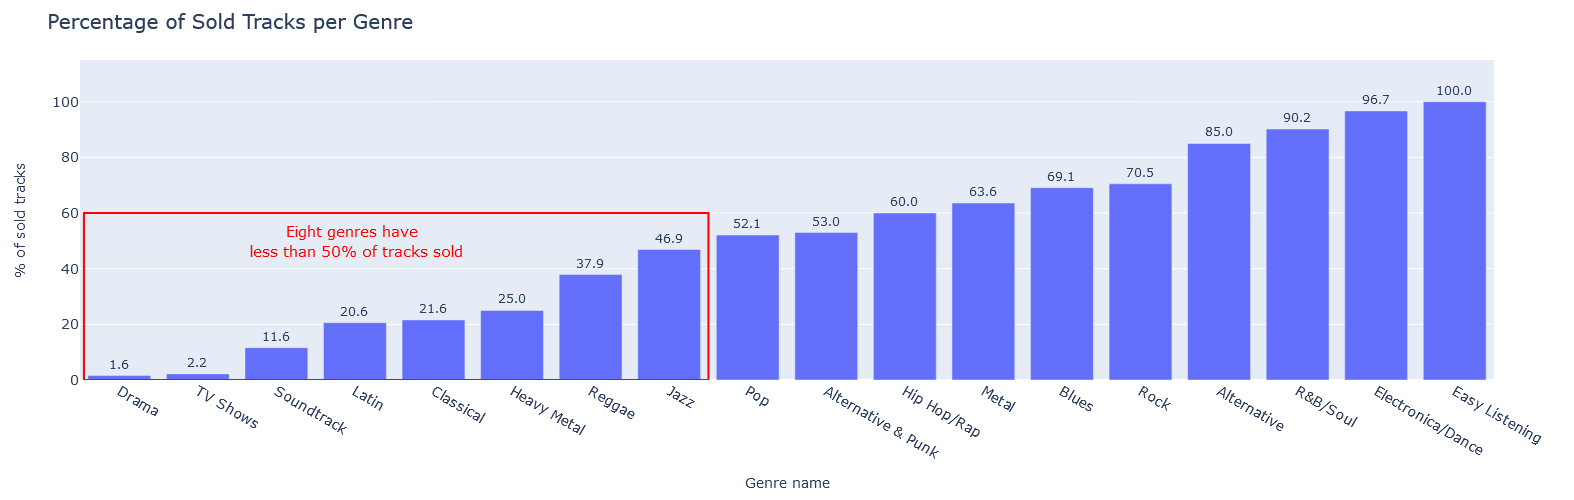

In [34]:
# Plot
fig5 = px.bar(sales_popularity, x="name", y="percentage_sold", text="percentage_sold", width=1000, height=500)

# Data labels
fig5.update_traces(texttemplate="%{text:.1f}", textposition="outside")

# Title
fig5.update_layout(
    title={
        "text": "Percentage of Sold Tracks per Genre",
        "x": 0.03,
        "y": 0.97,
        "font": dict(
            size=20
        )
    }
)

# Text in the box
fig5.update_layout(
    annotations=[
        dict(
            x=3,
            y=50,
            text="Eight genres have <br> less than 50% of tracks sold",
            showarrow=False,
            font=dict(
                size=15, color="red"
            )
        )
    ]
)

# Emphasize genres with less than 50% of tracks sold
fig5.add_shape(
        # unfilled Rectangle
            type="rect",
            x0=-0.45,
            y0=60,
            x1=7.5,
            y1=0,
            line=dict(
                color="Red",
            ),
        )

# x and y labels
fig5.update_xaxes(title="Genre name",  tickfont=dict(size=14))
fig5.update_yaxes(title="% of sold tracks", tickfont=dict(size=14), range=[0,115])

As we can observe eight genres - **Drama, TV Shows, Soundtrack, Latin, Classical, Heavy Metal, Reggae, and Jazz** - have less than 50% of tracks sold out of all available tracks for these genres. Chinook should address this problem by excluding these tracks from its library to reduce losses.

## Is the Range of Tracks in the Store Reflective of Their Sales Popularity?

Lastly, we will draw a scatter plot to understand if the range of tracks reflects their sales popularity. To avoid the range of points to be too wide we will initially exclude the genres that have more than 200 available tracks (Rock, Latin, Metal and Alternative & Punk). And then we will draw a separate scatter plot for the latter genres.

In [25]:
sales_popularity.sort_values(by="no_tracks", ascending=False)

name  no_tracks  unique_tracks_sold  percentage_sold
13                Rock       1297                 915             70.5
3                Latin        579                 119             20.6
11               Metal        374                 238             63.6
9   Alternative & Punk        332                 176             53.0
7                 Jazz        130                  61             46.9
1             TV Shows         93                   2              2.2
12               Blues         81                  56             69.1
4            Classical         74                  16             21.6
0                Drama         64                   1              1.6
15            R&B/Soul         61                  55             90.2
6               Reggae         58                  22             37.9
8                  Pop         48                  25             52.1
2           Soundtrack         43                   5             11.6
14         Alternative         40                  34             85.0
10         Hip Hop/Rap         35                  21             60.0
16   Electronica/Dance         30                  29             96.7
5          Heavy Metal         28                   7             25.0
17      Easy Listening         24                  24            100.0

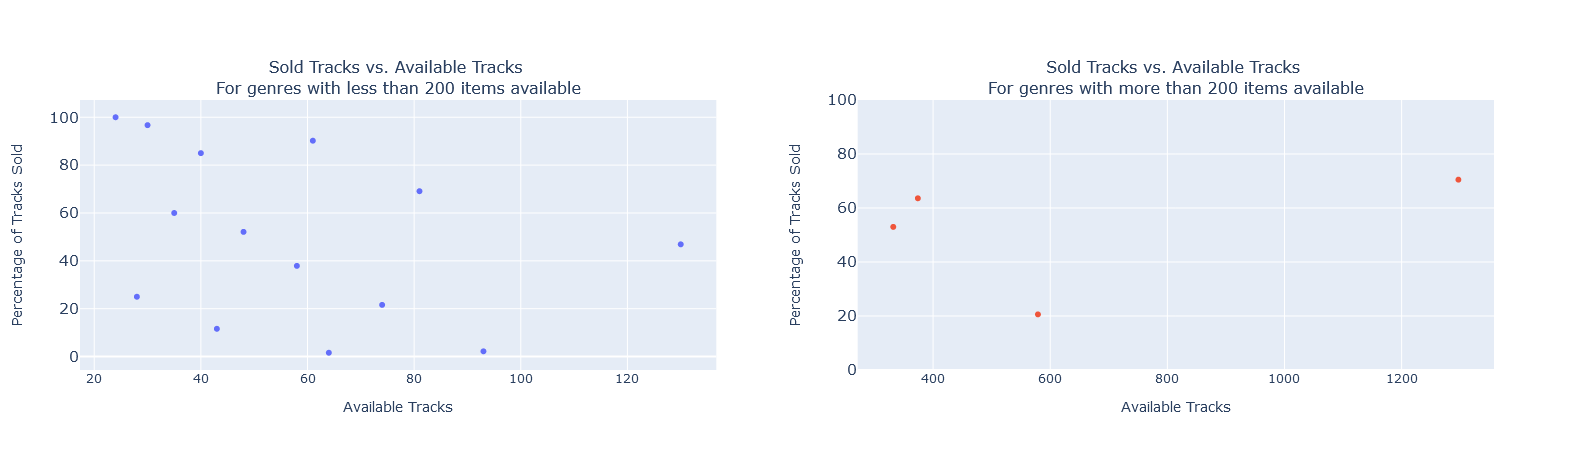

In [28]:
# Filter genres with less than 200 available tracks
less_than_200 = sales_popularity["no_tracks"] < 200

# Initialize 2 subplots in a row
fig6 = make_subplots(
    rows=1, cols=2,
    subplot_titles=[
        "Sold Tracks vs. Available Tracks <br>For genres with less than 200 items available", 
        "Sold Tracks vs. Available Tracks <br>For genres with more than 200 items available"
    ]
)

# First plot
fig6.add_trace(
    go.Scatter(
        x=sales_popularity[less_than_200]["no_tracks"],
        y=sales_popularity[less_than_200]["percentage_sold"],
        mode="markers",
        text=sales_popularity[less_than_200]["name"]
    ),
    row=1,
    col=1
)

# Second plot
fig6.add_trace(
    go.Scatter(
        x=sales_popularity[~less_than_200]["no_tracks"],
        y=sales_popularity[~less_than_200]["percentage_sold"],
        mode="markers",
        text=sales_popularity[~less_than_200]["name"]
    ),
    row=1,
    col=2
)

# Remove legend
fig6.update_layout(showlegend=False)

# Axes labels
fig6.update_yaxes(title_text="Percentage of Tracks Sold", tickfont=dict(size=15), row=1, col=1)
fig6.update_yaxes(title_text="Percentage of Tracks Sold", tickfont=dict(size=15), row=1, col=2, range=[0, 100])

for i in range(1, 3):
    fig6.update_xaxes(title_text="Available Tracks", row=1, col=i)

# Show plot
fig6.show()

There is no connection between the range of available tracks and sales popularity.

## Conclusions 

In this project, we analyzed a database of the fictional digital music store Chinook and provided the best business strategies to follow in order to reduce losses and increase profits. In particular, Chinook should:

* Should buy tracks by the following artists: Red Tone (Red Tone), Meteor and the Girls (Pop), Slim Jim Bites (Blues).
* Should concentrate on the Rock genre since it possess more than 50% of the USA market
* Expand in the Czech Republic which has the best potential customer sales.
* Do not forget about the USA market since it's the biggest and the most important one.
* Prefer buying not-protected media type to protected.
* Reconsider its purchasing strategy, since almost half of the available tracks in Chinook is not purchased, especially in the genres of Drama, TV Shows, Soundtrack, Latin, Classical, Heavy Metal, Reggae, and Jazz that have less than 50% of the available tracks sold.